In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import math
import pickle as pkl
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/PDFs")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/DetResponse")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/Utils")

from Detector import *
from Signal import *
from Plot_Histogram import *
from Background import *
from Plot_Histogram import *
from Utils import *

from modeling import PdfBase, Model, Parameter
from data import DataSet
from llh import LikelihoodRatioTest
import matplotlib.pyplot as plt
#Change the resolution of the plots
# plt.rcParams['figure.dpi']= 200

# <font color="darkmagenta"> Expected event distribution in OscNext for: Background (atm neutrinos), DM signal, GC astro flux </font>

In [2]:
def GC_spectra(E_GC):
    # Galactic Diffuse flux - pi0 model:
    # Icecube paper give: 21.8 x 10−12 [TeV cm−2 s−1] at 100 TeV as E^2 dN/dE
    # return: GeV^{-1} cm^{-2} s^{-1} per flv
    norm = 21.8 * 1e-12 *1e3/(pow(100.*1e3,-0.7))
    f_GC = norm* pow(E_GC, -2.7)
    return f_GC



[]

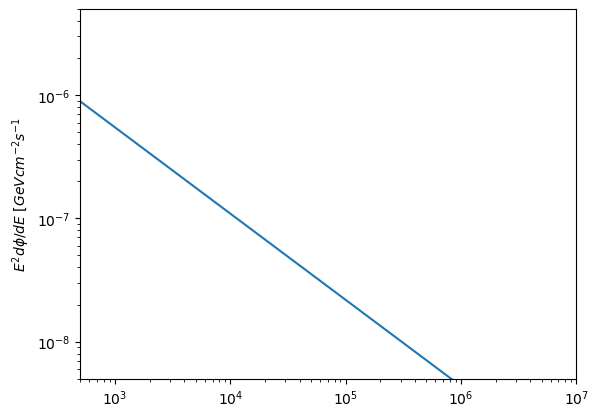

In [3]:
# Galactic Diffuse flux - pi0 model:
# Norm: 21.8 x 10^−12 [TeV cm−2 s−1] at 100 TeV as E^2 dN/dE
norm = 21.8 * 1e-12 *1e3/(pow(100.*1e3,-0.7))
E_GC = np.logspace(np.log10(1e2), np.log10(1e6))
f_GC = norm* pow(E_GC, -0.7)
plt.plot(E_GC, f_GC)
plt.ylabel(r'$E^{2} d\phi/dE$ $[GeV cm^{-2} s^{-1}$')
plt.xlim(5e2, 1e7)
plt.ylim(5e-9, 5e-6)
plt.semilogx()
plt.semilogy()

In [21]:
# Darkmatter:
# channel and mass
channel = "WW"
mass = 8000
profile='NFW'
xsec = 1e-23

def DMTrueRate(channel, mass, profile, xsec):
    Bin = Std_Binning(mass, N_Etrue=500)
    Reco = RecoRate(channel, 
            mass, 
            profile, 
            Bin,
            type="Resp",
            set='1122',
            spectra='Charon'
            )
    Reco.ResetAllHists()
    TrueRate = Reco.ComputeTrueRate()
    DMRate = np.zeros(TrueRate['nu_e'].shape[1])
    for flv in ['nu_e', 'nu_mu', 'nu_tau', 'nu_e_bar', 'nu_mu_bar', 'nu_tau_bar']:
        DMRate += [xsec*np.sum(TrueRate[flv][:,i] *2*np.pi*np.sin(np.deg2rad(Bin['true_psi_center'])) ) for i in range(TrueRate[flv].shape[1])]
    # Integral in all direction:
    DMRate = DMRate* np.deg2rad(Bin['true_psi_center'][1] - Bin['true_psi_center'][0])
    return DMRate, Bin['true_energy_center']

DMRate, EDM =  DMTrueRate(channel, mass, profile, xsec)

********************
Computing true rate with Charon spectra
channel: WW || mass: 8000 || profile: NFW || process: ann

********************
Computing Spectra
Initial Flux Loading: /home/tchau/.local/lib/python3.10/site-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
********************
Computing Jfactor with default option: precomputed Clumpy file


[]

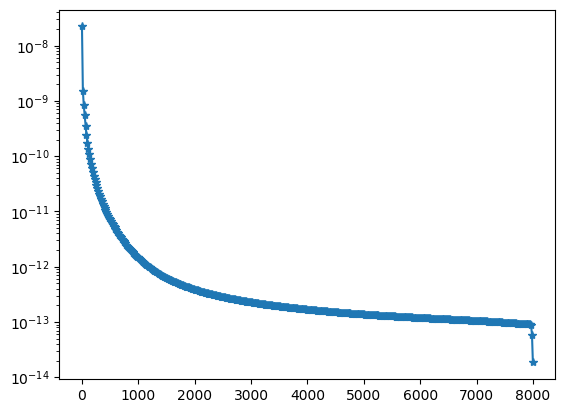

In [22]:
plt.plot(EDM,DMRate, marker='*')
# plt.semilogx()
plt.semilogy()

In [23]:
# Honda atmospheric flux:
file = open('/data/user/tchau/Sandbox/GC_OscNext/PlotScripts/HKKMSP.txt', "r")
lines=file.readlines()
HKKM=dict()
HKKM['E'] = np.array([])
HKKM['nu_mu'] = np.array([])
HKKM['nu_mu_bar'] = np.array([])
HKKM['nu_e'] = np.array([])
HKKM['nu_e_bar'] = np.array([])

for x in lines[2:-1]:
    i = 0
    for k in HKKM.keys():
        i+=1
        if k=='E':
            HKKM[k] = np.append(HKKM[k],float(x.split(' ')[i]))  
        else:
            HKKM[k] = np.append(HKKM[k],2*2*np.pi*1E-4*float(x.split(' ')[i]))  # (m^2 sec sr GeV)^-1  -> (cm^2 sec sr GeV)^-1
file.close()


********************
Computing true rate with Charon spectra
channel: WW || mass: 100 || profile: NFW || process: ann

********************
Computing Spectra
Initial Flux Loading: /home/tchau/.local/lib/python3.10/site-packages/charon-0.1.0-py3.10.egg/charon/data/Spectra_PYTHIA.hdf5
********************
Computing Jfactor with default option: precomputed Clumpy file
********************
Computing true rate with Charon spectra
channel: numunumu || mass: 200 || profile: NFW || process: ann

********************
Computing Spectra
Initial Flux Loading: /home/tchau/.local/lib/python3.10/site-packages/charon-0.1.0-py3.10.egg/charon/data/Spectra_PYTHIA.hdf5
********************
Computing Jfactor with default option: precomputed Clumpy file


[]

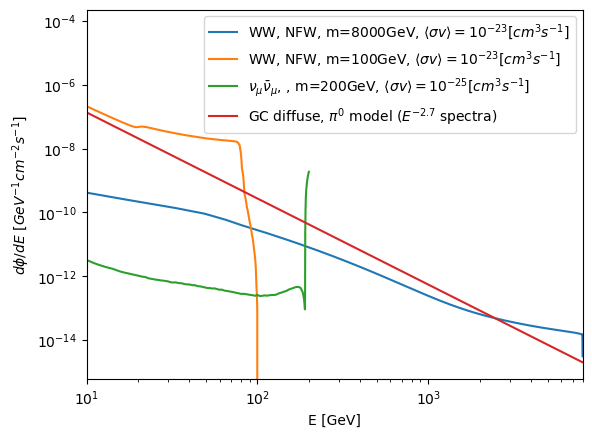

In [7]:
# plt.plot(HKKM['E'], HKKM['nu_mu'], label='atm - HKKM')
plt.plot(EDM,DMRate/6., label=f'{channel}, {profile}, m={mass}GeV, '+r'$\langle \sigma v\rangle = 10^{-23} [cm^{3}s^{-1}]$')

DMRate2, EDM2 =  DMTrueRate('WW', 100, 'NFW', xsec)
plt.plot(EDM2,DMRate2/6., label=f'{channel}, {profile}, m=100GeV, '+r'$\langle \sigma v\rangle = 10^{-23} [cm^{3}s^{-1}]$')

# DMRate2, EDM2 =  DMTrueRate('WW', 8000, 'NFW', 1e-26)
# plt.plot(EDM2,DMRate2/6., label=f'{channel}, {profile}, m=8000GeV, '+r'$\langle \sigma v\rangle = 10^{-26} [cm^{3}s^{-1}]$')

DMRate3, EDM3 =  DMTrueRate('numunumu', 200, 'NFW', 1e-25)
plt.plot(EDM3,DMRate3/6., label=r'$\nu_{\mu}\bar{\nu}_{\mu}$, , m=200GeV, '+r'$\langle \sigma v\rangle = 10^{-25} [cm^{3}s^{-1}]$')

E_GC = np.logspace(np.log10(1), np.log10(8000))
f_GC = GC_spectra(E_GC)
plt.plot(E_GC, f_GC, label=r'GC diffuse, $\pi^0$ model ($E^{-2.7}$ spectra)')
plt.legend()
plt.xlim(10, 8E3)
# plt.ylim(1E-8, 1E-5)

plt.ylabel(r'$d\phi/dE$ $[GeV^{-1} cm^{-2} s^{-1}]$')
plt.xlabel(r'E [GeV]')

plt.semilogy()
plt.semilogx()

In [9]:
# In term of reco event


def DMRecoRate(channel, mass, profile, xsec):
    if mass>3000:
        Bin = Std_Binning(3000, N_Etrue=500)
    else:
        Bin = Std_Binning(mass, N_Etrue=500)
    Reco = RecoRate(channel, 
            mass, 
            profile, 
            Bin,
            type="Resp",
            set='1122',
            spectra='Charon'
            )
    Reco.ResetAllHists()
    DMReco = Reco.ComputeRecoRate()
    DMRateE = [xsec*np.sum(DMReco[:,i]) for i in range(DMReco.shape[1])]


    return DMRateE, Bin['reco_energy_center']

DMReco, EDMReco = DMRecoRate(channel, mass, profile, xsec) 

********************
Buiding final reco rate using Resp method
********************
Computing true rate with Charon spectra
channel: WW || mass: 8000 || profile: NFW || process: ann

********************
Computing Spectra
Initial Flux Loading: /home/tchau/.local/lib/python3.10/site-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
********************
Computing Jfactor with default option: precomputed Clumpy file
********************
Computing Response Matrix
********************
Accessing MC set 1122


In [41]:
Bin = Std_Binning(mass, N_Etrue=10)
BkgPDF = ScrambleBkg(Bin, bw="ISJ", oversample=10)
BurnSample = DataHist(Bin)
BkgRate = 10*np.sum(BurnSample)*BkgPDF/(np.sum(BkgPDF))/(8*365*24*60*60.)
BkgRateE = [np.sum(BkgRate[:,i]) for i in range(BkgRate.shape[1])]


NameError: name 'mass' is not defined

Compute the reco events of GC flux -> assuming signal flat in a region with an fefine open angle

In [23]:
set='1122'
MCdict = ExtractMC(['14'+set, '12'+set, '16'+set])

MaxPsi = 180
MaxSolid = 2*np.pi*( 1-np.cos(np.deg2rad(MaxPsi)) )

nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}

loc = np.where( (MCdict["psi_true"]<MaxPsi) )

##Simulation weight##
genie_w = MCdict["w"][loc]

##Reco variables:
reco_E = MCdict["E_reco"][loc]
true_E = MCdict["E_true"][loc]


weight = genie_w * GC_spectra(true_E)/(MaxSolid)

Ereco_edges = Bin["reco_energy_edges"]
GC_recorate, v0_edges = np.histogram(reco_E,
                                    bins = (Ereco_edges),
                                    weights=weight)

[]

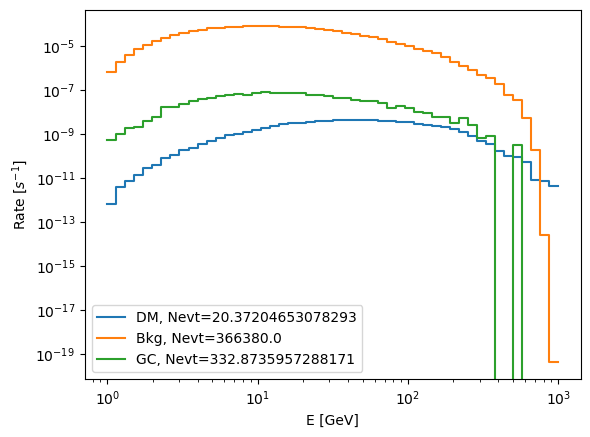

In [12]:
Eedges, DM = hist_line(DMReco, Bin['reco_energy_edges'])
Eedges, Bkg = hist_line(BkgRateE, Bin['reco_energy_edges'])
Eedges, GC = hist_line(GC_recorate, Bin['reco_energy_edges'])


plt.plot(Eedges, DM, label=f'DM, Nevt={np.sum(DMReco)*(8*365*24*60*60.)}')
plt.plot(Eedges, Bkg, label=f'Bkg, Nevt={np.sum(BkgRateE)*(8*365*24*60*60.)}')
plt.plot(Eedges, GC, label=f'GC, Nevt={np.sum(GC_recorate)*(8*365*24*60*60.)}')
plt.legend()
plt.ylabel(r'Rate $[s^{-1}]$')
plt.xlabel(r'E [GeV]')

plt.semilogx()
plt.semilogy()

In [21]:
# Testing the implemented function in Background
def SpatialPDF(psi):
    return 1.
Ratetest = GC_RecoEvt(Bin, SpatialPDF)
RateEtest = [np.sum(Ratetest[:,i]) for i in range(Ratetest.shape[1])]


[]

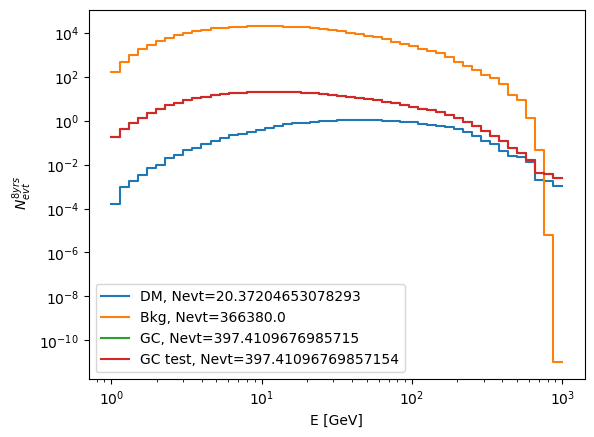

In [24]:
Eedges, DM = hist_line(DMReco, Bin['reco_energy_edges'])
Eedges, Bkg = hist_line(BkgRateE, Bin['reco_energy_edges'])
Eedges, GC = hist_line(GC_recorate, Bin['reco_energy_edges'])
Eedges, GCtest = hist_line(RateEtest,  Bin['reco_energy_edges'])

plt.plot(Eedges, DM*(8*365*24*60*60.), label=f'DM, Nevt={np.sum(DMReco)*(8*365*24*60*60.)}')
plt.plot(Eedges, Bkg*(8*365*24*60*60.), label=f'Bkg, Nevt={np.sum(BkgRateE)*(8*365*24*60*60.)}')
plt.plot(Eedges, GC*(8*365*24*60*60.), label=f'GC, Nevt={np.sum(GC_recorate)*(8*365*24*60*60.)}')

plt.plot(Eedges, GCtest*(8*365*24*60*60.), label=f'GC test, Nevt={np.sum(RateEtest)*(8*365*24*60*60.)}')


plt.legend()
plt.ylabel(r' $N^{8yrs}_{evt}$')
plt.xlabel(r'E [GeV]')

plt.semilogx()
plt.semilogy()

Let try to find the cross-section that give sensitivity!

In [14]:
ch = 'WW'
mass = 8000
pr = 'NFW'
Bin = Std_Binning(3000, N_Etrue=100)
Reco = RecoRate(ch, mass, pr, Bin, type="Resp", spectra='Charon', set='1122')
Bkg = ScrambleBkg(Bin, bw='ISJ', method='FFT' ,oversample=10)   
BurnSample = DataHist(Bin)

# Signal Rate and Scrambled Signal Rate
Rate = Reco.ComputeRecoRate()
Reco.ResetAllHists()
Reco.Scramble = True
Rate_Scr = Reco.ComputeRecoRate()

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2012_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2013_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2014_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2015_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2016_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscNext/Samples/OscNext/L7/Burnsample/OscNext_Level7_v02.00_burnsample_2017_pass2_variables_NoCut.pkl

Loading file: 
/data/user/niovine/projects/DarkMatter_OscN

In [15]:

# Signal PDF objects:
SignalPDF = PdfBase(Rate.flatten()/np.sum(Rate.flatten()), name="SignalPDF")
SignalPDF_Scr = PdfBase(Rate_Scr.flatten()/np.sum(Rate_Scr.flatten()), name="ScrSignalPDF")

# Pseudo data:
sig_fit = Parameter(value=0.5, limits=(0,1), fixed=False, name="sig_fit") # parameter used for fitting
sig_inj = Parameter(value=0.0, limits=(0,1), fixed=True, name="sig_inj") # asumming true
sig_fix = Parameter(value=0.0, limits=(0,1), fixed=True, name="sig_fix") #  case the null hypothesis has a fix injection

pseudo_data = (sig_inj* SignalPDF) + (1-sig_inj)*(BkgPDF)

# Background build from scramble data (pseudodata)
BkgPDF = PdfBase(Bkg.flatten()/np.sum(Bkg.flatten()), name="Bkg")
ScrBkg = (sig_inj* SignalPDF_Scr) + (1-sig_inj)*BkgPDF

# Models:
#  null hypothesis
modelH0 = sig_fix* SignalPDF + ScrBkg - sig_fix* SignalPDF_Scr
modelH1 = sig_fit* SignalPDF + ScrBkg - sig_fit* SignalPDF_Scr

lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0)


Parameter sig_inj already exists in the model, it won't be added again
PDF ScrSignalPDF already exists in the model, it won't be added again
Parameter sig_fix already exists in the model, it won't be added again
PDF ScrSignalPDF already exists in the model, it won't be added again
Parameter sig_fit already exists in the model, it won't be added again


In [16]:
#First let do the trial on null hypothesis and make a TS distribution
TS = np.array([])
for i in range(5):
    ds = DataSet()
    ds.sample(10*np.sum(BurnSample), pseudo_data)
    lr.data = ds
    lr.fit('H1')
    lr.fit('H0')
    TS = np.append(TS, lr.TS)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

(array([193.,  33.,  36.,  20.,  16.,  17.,  10.,  18.,  13.,   6.,   5.,
          9.,   8.,  10.,   6.,   7.,  11.,   4.,   3.,   5.,   5.,   6.,
          2.,   5.,   9.,   4.,   2.,   2.,   4.,   1.,   4.,   4.,   4.,
          3.,   4.,   7.,   0.,   2.,   2.,   3.,   5.,   3.,   0.,   1.,
          1.,   3.,   2.,   2.,   2.,   1.,   1.,   3.,   1.,   2.,   2.,
          3.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.06060606, 0.12121212, 0.18181818, 0.24242424,
        0.3030303 , 0.36363636, 0.42424242, 0.48484848, 0.54545455,
        0.60606061, 0.66666667, 0.72727273, 0.78787879, 0.84848485,
        0.90909091, 0.96969697, 1.03030303, 1.09090909, 1.15151515,
        1.21212121, 1.27272727, 1.33333333, 1.39393939, 1.45

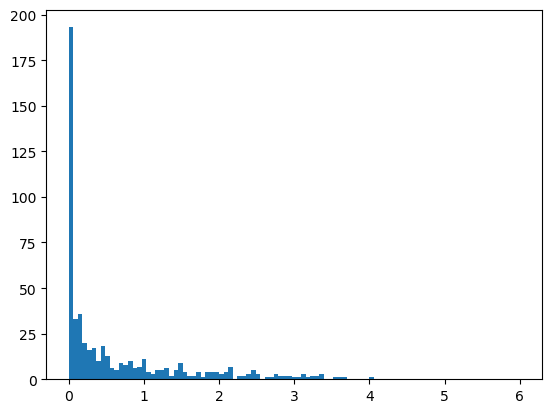

In [ ]:
plt.hist(TS, np.linspace(0, 6, 100))

In [ ]:
print(modelH1)

 Model: sig_fit*SignalPDF + sig_inj*ScrSignalPDF + (1-sig_inj) * Bkg - sig_fit*ScrSignalPDF
 Number of pdf: 3
 - SignalPDF
 - ScrSignalPDF
 - Bkg
 Number of parameters: 2
 Name: sig_fit, Value: 0.50, Scale: 1.0e+00, Limits: (0.0, 1.0), Fixed: False, Is nuisance? False
 Name: sig_inj, Value: 0.00, Scale: 1.0e+00, Limits: (0.0, 1.0), Fixed: True, Is nuisance? False


In [ ]:
inj = 1e-25
pseudo_data.parameters['sig_inj'].value = inj
ds.asimov(10*np.sum(BurnSample), pseudo_data)
lr.data = ds
lr.fit('H1')
lr.fit('H0')
dTS=0
while dTS<1.96*1.96:
    inj += 3.*inj
    pseudo_data.parameters['sig_inj'].value = inj
    ds.asimov(10*np.sum(BurnSample), pseudo_data)
    lr.data = ds
    lr.fit('H1')
    lr.fit('H0')
    dTS = lr.TS
print(dTS)
parup = inj
parlow = inj/2.   
par = (parup+parlow)/2.

print(f'range for searching: {parlow} {parup}')
dTS = lr.TS
while (abs(np.sqrt(dTS)-1.96)< 0.001):
    par = (parup+parlow)/2.
    pseudo_data.parameters['sig_inj'].value = par
    ds.asimov(10*np.sum(BurnSample), pseudo_data)
    lr.data = ds
    lr.fit('H1')
    lr.fit('H0')
    dTS = lr.TS
    if (dTS > 1.96*1.96):
        parup=par
    else:
        parlow=par

/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/RHEL_7_x86_64/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


3.862676029559225
range for searching: 0.00023611832414348227 0.00047223664828696454


In [ ]:
par

0.0003541774862152234

In [ ]:
pseudo_data.parameters['sig_inj'].value = par
ds.asimov(10*np.sum(BurnSample), pseudo_data)
lr.data = ds
lr.fit('H1')
lr.fit('H0')
lr.TS

2.6652099643833935

In [ ]:
par* 10*np.sum(BurnSample)

129.76354739953356

In [ ]:
1.96*1.96

3.8415999999999997

# <font color="darkmagenta"> Pi0 template 

In [2]:
import healpy as hp
pi0 = np.load('/data/user/tchau/Sandbox/GC_OscNext/Fermi-LAT_pi0_map.npy')

# hp.mollview(
#     pi0,
#     coord=["E", "G"],
#     title=r"$\pi_0$ template",
#     unit="..",
#     # norm="hist",
# )
# hp.graticule()

In [3]:
nside = hp.npix2nside(pi0.size)

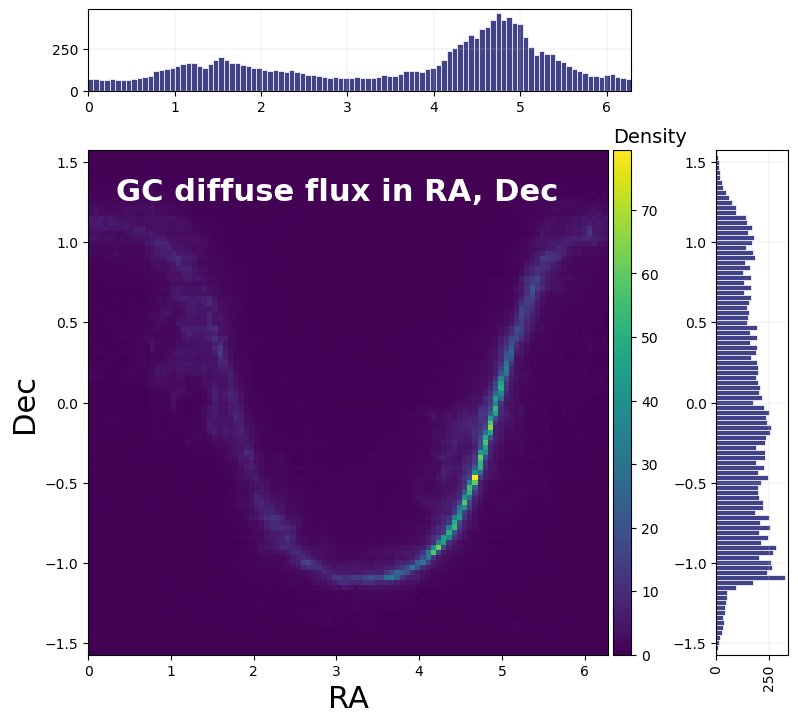

In [4]:
# Using skycoord:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy_healpix import HEALPix

hpix = HEALPix(nside=nside, frame='icrs')


c = hpix.healpix_to_skycoord(np.arange(0, pi0.size,1))
eq = c.icrs

RAedges = np.linspace(0, 2*np.pi, 101)
Decedges = np.linspace(-np.pi/2.,np.pi/2., 102)

GC_hist = np.histogram2d(eq.ra.radian, eq.dec.radian, [RAedges, Decedges], weights=pi0)
plot_projections(GC_hist[0], (RAedges,  Decedges), 'RA', 'Dec', 'GC diffuse flux in RA, Dec', norm=None, min=None, zlogscale=False)

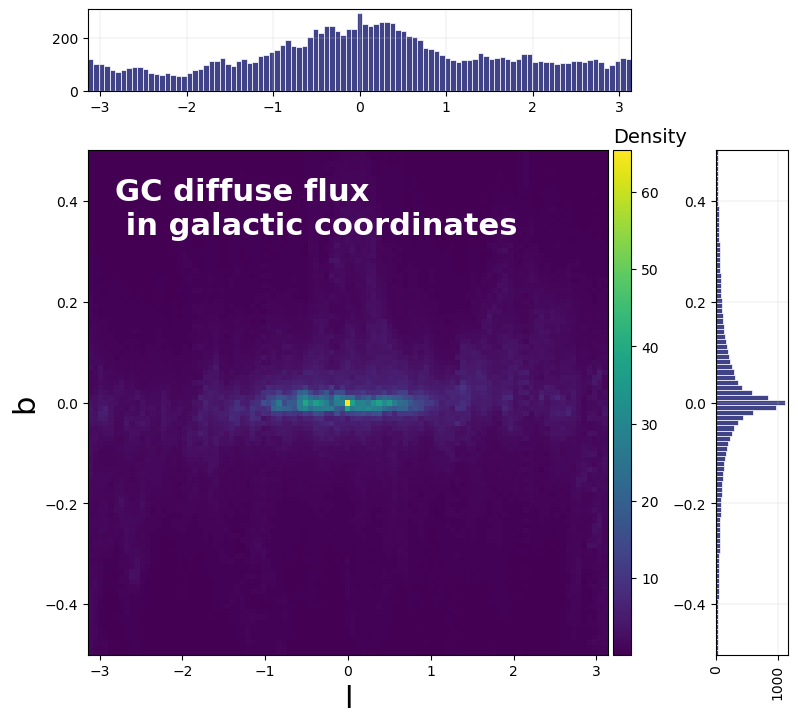

In [5]:
g = c.galactic

ledges = np.linspace(-np.pi,np.pi, 100)
bedges = np.linspace(-0.5,0.5, 100)

l_correct = g.l.radian
loc = np.where( (l_correct>np.pi) )
l_correct[loc] -= 2*np.pi 

GC_hist = np.histogram2d(l_correct, g.b.radian, [ledges, bedges], weights=pi0)
plot_projections(GC_hist[0], (ledges,  bedges), 'l', 'b', 'GC diffuse flux \n in galactic coordinates', norm=None, min=None, zlogscale=False)

(array([0.00896559, 0.0105672 , 0.01198661, 0.01246315, 0.01348169,
        0.01329548, 0.01300808, 0.01478187, 0.01591145, 0.01762178,
        0.01845461, 0.01822582, 0.01852185, 0.01777566, 0.01830559,
        0.01761619, 0.01666955, 0.01723545, 0.01434761, 0.0151351 ,
        0.01349552, 0.01384385, 0.0137664 , 0.01319834, 0.01251883,
        0.01315348, 0.01323185, 0.0128405 , 0.01197392, 0.01162415,
        0.01155745, 0.01110475, 0.01062066, 0.01013866, 0.01029542,
        0.00997685, 0.00958681, 0.0091413 , 0.00931578, 0.0092356 ,
        0.00924267, 0.00953746, 0.01021392, 0.0106995 , 0.00958508,
        0.00930705, 0.00911937, 0.0087121 , 0.00952481, 0.00996578,
        0.00995671, 0.00992238, 0.00934105, 0.00928031, 0.0093368 ,
        0.0089274 , 0.00853716, 0.00842894, 0.00847411, 0.00850743,
        0.00889074, 0.00923057, 0.0074486 , 0.00721112, 0.00675765,
        0.00712553, 0.00739216, 0.00709754, 0.00715946, 0.00716249,
        0.00774875, 0.00709443, 0.00710571, 0.00

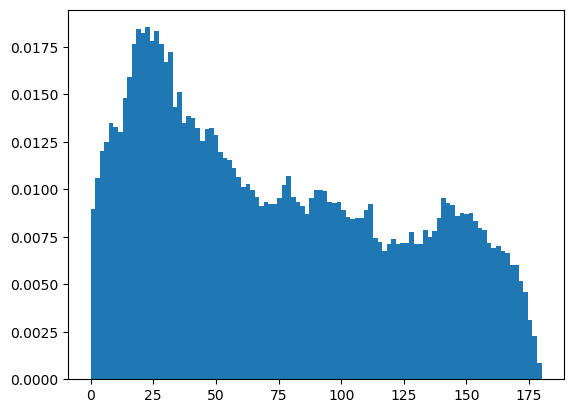

In [6]:
# Put the flux into the open angle:
CoordPsi = np.rad2deg(psi_f(eq.ra.rad, eq.dec.rad))
# GC_flux = np.histogram(Bin['true_psi_edges'], )
plt.hist(CoordPsi, np.linspace(0, 180, 100), weights=pi0/np.sum(pi0))

In [7]:
# The detector response function
DetResp = pkl.load(open('/data/user/tchau/Sandbox/GC_OscNext/DetResponse/PreComp/Resp_MC1122_logE.pkl', 'rb'))
Bin = DetResp['Bin']
Resp = DetResp['Resp']
Resp_Scr = DetResp['Resp_Scr']

In [8]:
np.sum(Resp['nu_e'])

123994.32817623595

In [19]:
Bin = Std_Binning(3000, N_Etrue=1000)
Reco = RecoRate('WW', 3000, 'NFW', Bin,set = '1122')
test = Reco.ComputeResp()

********************
Computing Response Matrix
********************
Accessing MC set 1122


In [20]:
np.sum(test['nu_e'])

119671.95283411525

In [21]:
GCflux, edges = np.histogram(CoordPsi, Bin['true_psi_edges'], weights=pi0)
GCNpoints, edges = np.histogram(CoordPsi, Bin['true_psi_edges'])
dpsi = np.deg2rad(Bin['true_psi_edges'][1] - Bin['true_psi_edges'][0])
GCflux = GCflux/(2*np.pi* np.sin(np.deg2rad(Bin['true_psi_center'])* dpsi))
# make the normalization:
GCflux /=np.sum(pi0)

In [10]:

GC_Spectra = GC_Espectra( Bin['true_energy_center'])
GC_TrueRate = np.array(GCflux[:,None]* GC_Spectra)

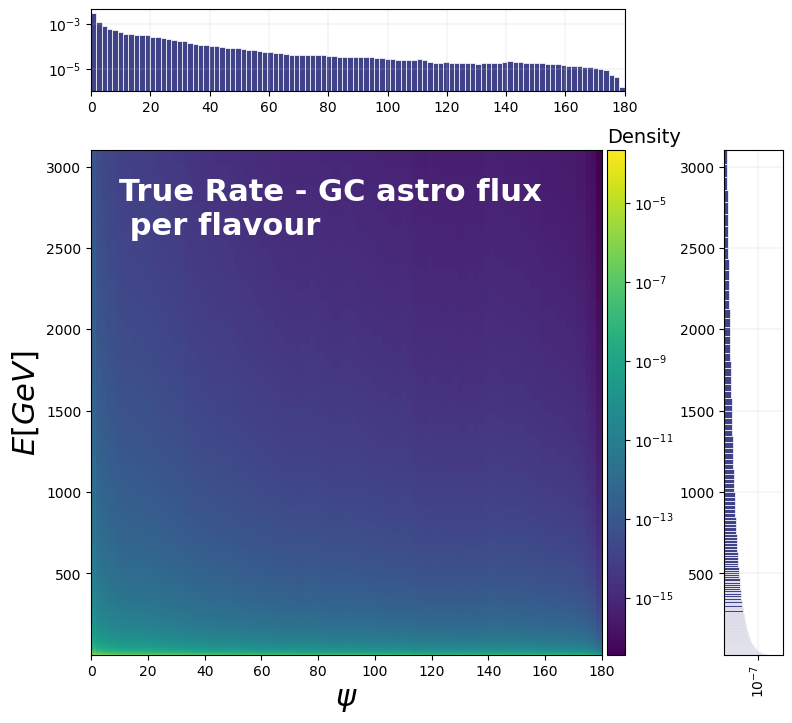

In [11]:
plot_projections(GC_TrueRate, (Bin['true_psi_edges'], Bin['true_energy_edges']), r'$\psi$', r'$E[GeV]$', 'True Rate - GC astro flux \n per flavour', norm=None, min=None, zlogscale=True)


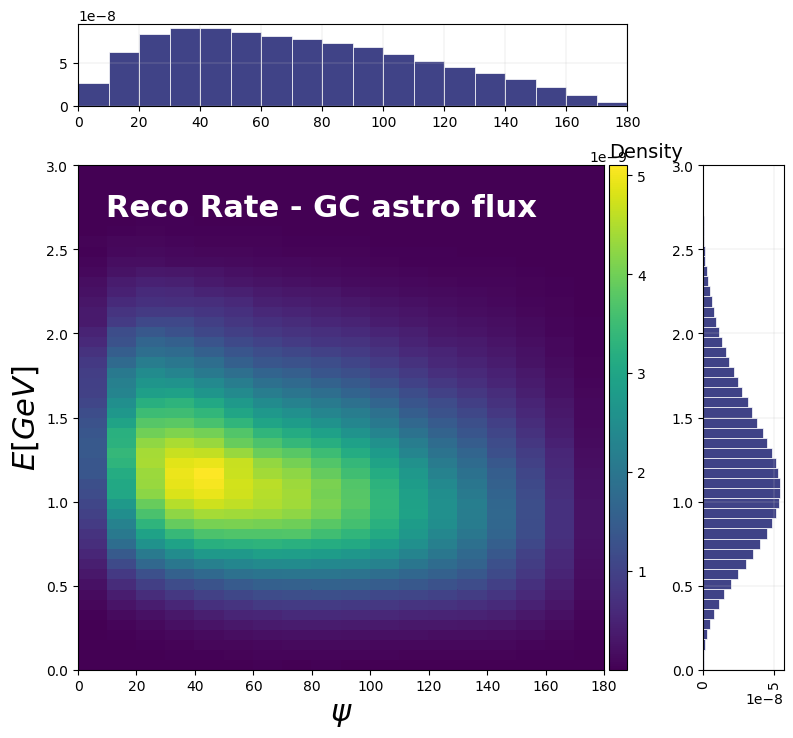

In [12]:
GC_RecoRate = np.zeros((Bin['reco_psi_center'].size, Bin['reco_energy_center'].size))
grid = np.meshgrid(Bin['true_psi_center'], Bin['true_energy_center'], 
            Bin['reco_psi_center'], np.log10(Bin['reco_energy_center']), indexing='ij')
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    totalIntegration = np.sum(Resp[nutype])
    Resp[nutype] = Resp[nutype]* grid[1]
    Resp[nutype] = Resp[nutype]/np.sum(Resp[nutype])* totalIntegration
    GC_RecoRate += np.tensordot(Resp[nutype], GC_TrueRate, axes=([0,1], [0,1]))
    
plot_projections(GC_RecoRate, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'Reco Rate - GC astro flux', norm=None, min=None, zlogscale=False)


In [13]:
np.sum(GC_RecoRate*8*365*24*60*60.)

255.1607593377155

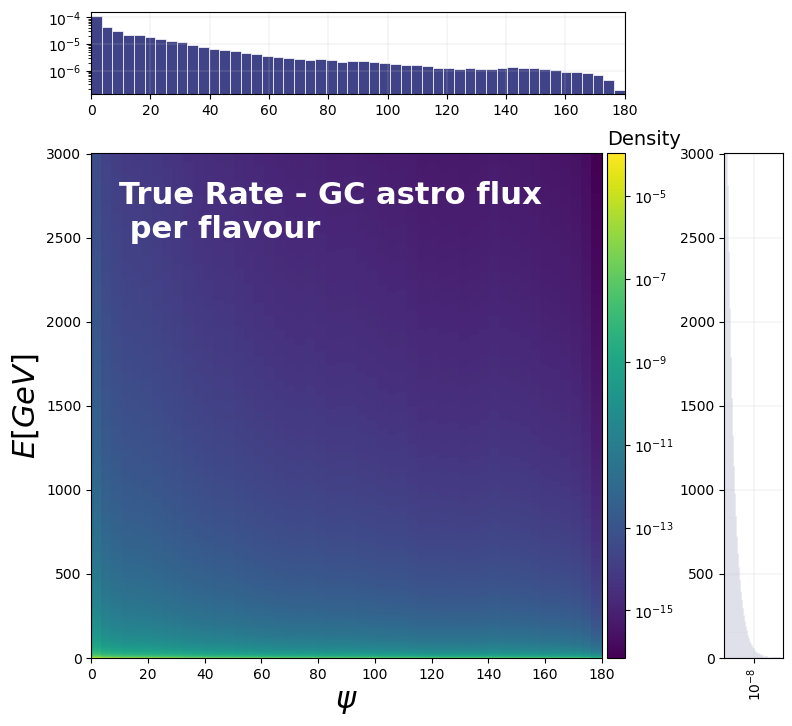

In [22]:
# Using the implemented interpolation (integration on linear E):
Bin = Std_Binning(3000, N_Etrue=1000)
Reco = RecoRate('WW', 200, 'NFW', Bin, set='1122')
GC_Spectra = GC_Espectra( Bin['true_energy_center'])

GCflux, edges = np.histogram(CoordPsi, Bin['true_psi_edges'], weights=pi0)
dpsi = np.deg2rad(Bin['true_psi_edges'][1] - Bin['true_psi_edges'][0])
GCflux = GCflux/(2*np.pi* np.sin(np.deg2rad(Bin['true_psi_center'])* dpsi))
# make the normalization:
GCflux /=np.sum(pi0)

GC_TrueRate = np.array(GCflux[:,None]* GC_Spectra)
GCdict = dict()
for nu in ['nu_e', 'nu_mu', 'nu_tau', 'nu_e_bar', 'nu_mu_bar', 'nu_tau_bar']:
    GCdict[nu] = GC_TrueRate
Reco.hist['TrueRate'] = GCdict

plot_projections(GC_TrueRate, (Bin['true_psi_edges'], Bin['true_energy_edges']), r'$\psi$', r'$E[GeV]$', 'True Rate - GC astro flux \n per flavour', norm=None, min=None, zlogscale=True)


********************
Buiding final reco rate using Resp method
********************
True rate already computed, will not compute it again
********************
Computing Response Matrix
********************
Accessing MC set 1122


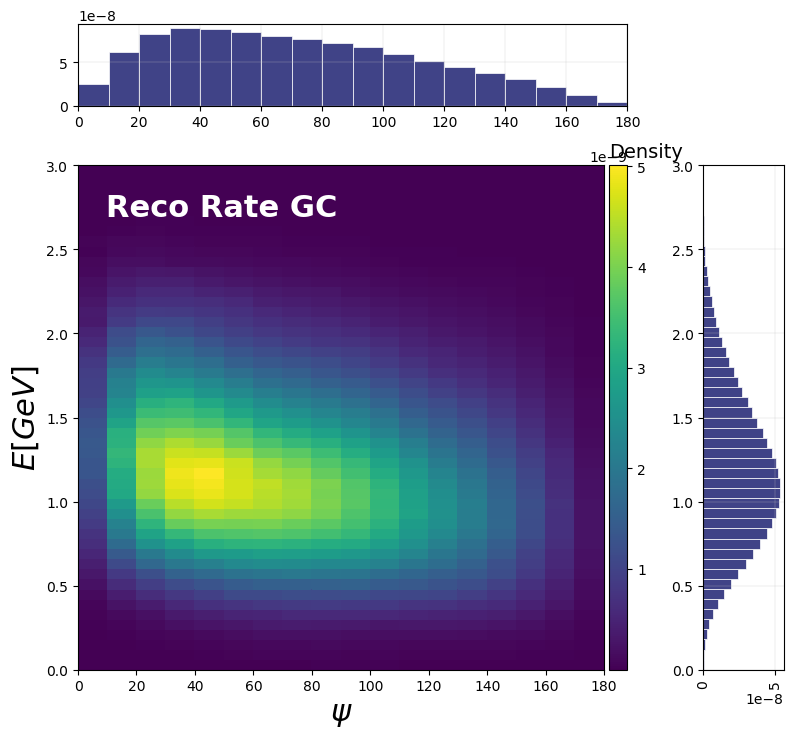

In [23]:
Reco.hist['Resp'] = None
GCreco = Reco.ComputeRecoRate()

plot_projections(GCreco, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'Reco Rate GC', norm=None, min=None, zlogscale=False)


In [24]:
np.sum(GCreco*8*365*24*60*60.)

251.105058227119

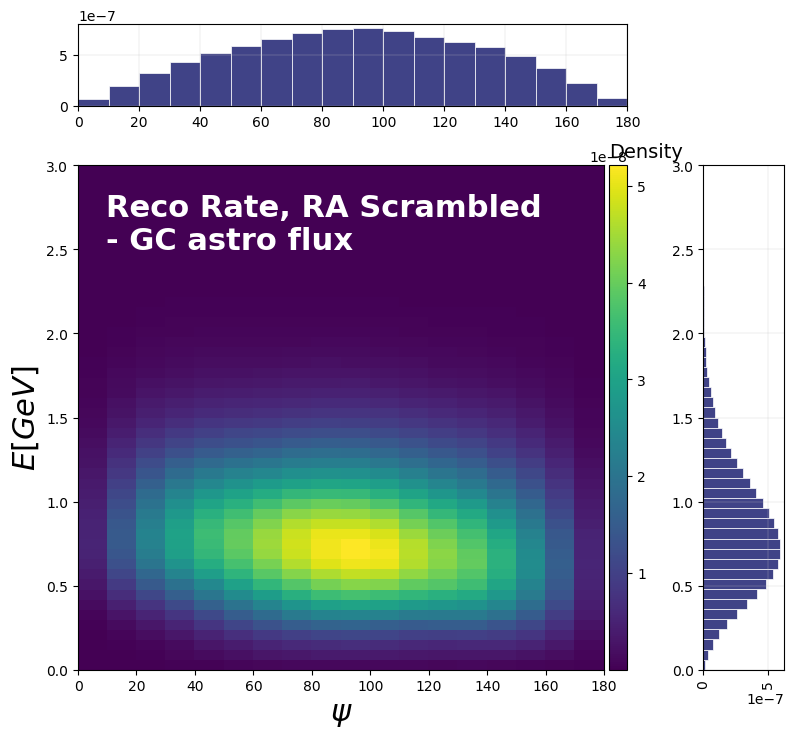

In [61]:
GC_RecoRate_Scr = np.zeros((Bin['reco_psi_center'].size, Bin['reco_energy_center'].size))
for nutype in ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]:
    GC_RecoRate_Scr += np.tensordot(Resp_Scr[nutype], GC_TrueRate, axes=([0,1], [0,1]))
plot_projections(GC_RecoRate, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'Reco Rate, RA Scrambled \n- GC astro flux', norm=None, min=None, zlogscale=False)


In [62]:
np.sum(GC_RecoRate_Scr*8*365*24*60*60.)

2209.107313209799

# <font> test with evt by evt reweight 

In [4]:

# load the pi0 and extract the equatorial coodinate
pi0 = np.load('/data/user/tchau/Sandbox/GC_OscNext/Fermi-LAT_pi0_map.npy')
nside = hp.npix2nside(pi0.size)
hpix = HEALPix(nside=nside, frame='icrs')
c = hpix.healpix_to_skycoord(np.arange(0, pi0.size,1))
eq = c.icrs

# since the healpix is defined such that each index have the same solid angle. The differential flux should be computed as followed:
# solid angle for each pixel:
dOmg = 4*np.pi/(pi0.size)
pi0 = pi0/(np.sum(pi0) *dOmg)

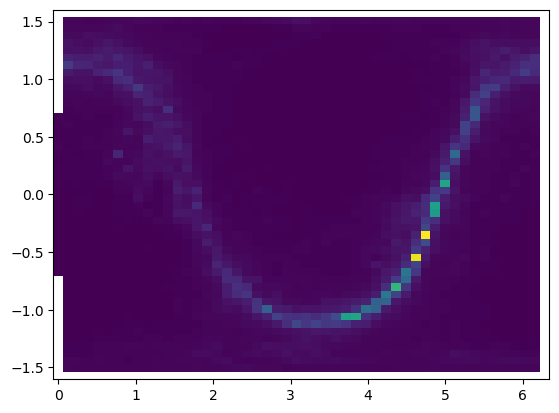

In [5]:
# test using scipy interpolate
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(list(zip(eq.ra.rad, eq.dec.rad)), pi0)

X,Y = np.meshgrid( np.linspace(0, 2*np.pi, 50), np.linspace(-np.pi/2., np.pi/2., 50 ) )

Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto')
# np.sum(Z)

In [6]:
# Taking the MC:
set='1122'
MCdict = ExtractMC(['14'+set, '12'+set, '16'+set])

##Simulation weight##
genie_w = MCdict["w"]

##Reco variables:
reco_E = MCdict["E_reco"]
true_E = MCdict["E_true"]
reco_psi = MCdict["psi_reco"]
true_psi = MCdict["psi_true"]
true_RA = MCdict["RA_true"]
true_Dec = MCdict["Dec_true"]
reco_RA = MCdict["RA_reco"]
reco_Dec = MCdict["Dec_reco"]

interpolate using Healpix bilinear interpolate method vs using ND liner interpolator of numpy

In [7]:
Bin = Std_Binning(3000)
coords_plot = SkyCoord(true_RA, true_Dec, frame='icrs', unit='rad')


Z = hpix.interpolate_bilinear_skycoord(coords_plot, pi0)
# Z = interp(true_RA, true_Dec)
# loc = np.where(Z!=Z)
# Z[loc] = 0
weights = Z* GC_Espectra(true_E) * genie_w

# GC_recorate_evtbyevt, edges1, edges2 = np.histogram2d(reco_psi, reco_E, bins = (Bin['reco_psi_edges'], Bin['reco_energy_edges']), weights=weights)

GC_recorate_evtbyevt, edges1, edges2 = np.histogram2d(reco_RA, reco_Dec, bins = ( np.linspace(0, 2*np.pi, 100), np.linspace(-np.pi/2., np.pi/2., 100 ) ), weights=weights)

In [8]:
np.sum(GC_recorate_evtbyevt)*8*365*24*60*60

385.73541489246804

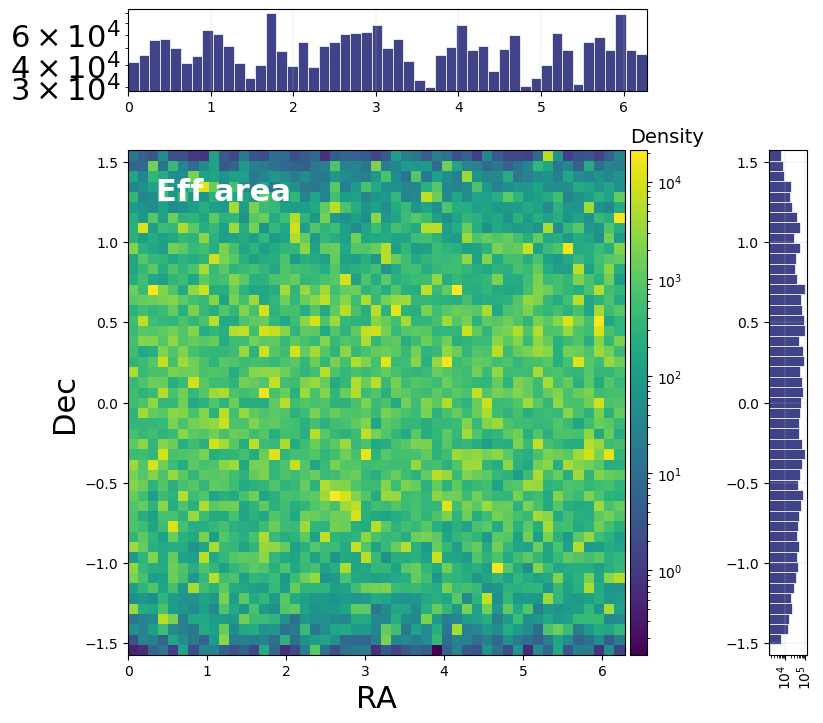

In [45]:
Eff, edges1, edges2 = np.histogram2d(true_RA, true_Dec, bins = ( np.linspace(0, 2*np.pi, 50), np.linspace(-np.pi/2., np.pi/2., 50 ) ), weights=genie_w)
plot_projections(Eff, ( edges1, edges2 ), r'RA', r'Dec', 'Eff area', norm=None, min=None, zlogscale=True)


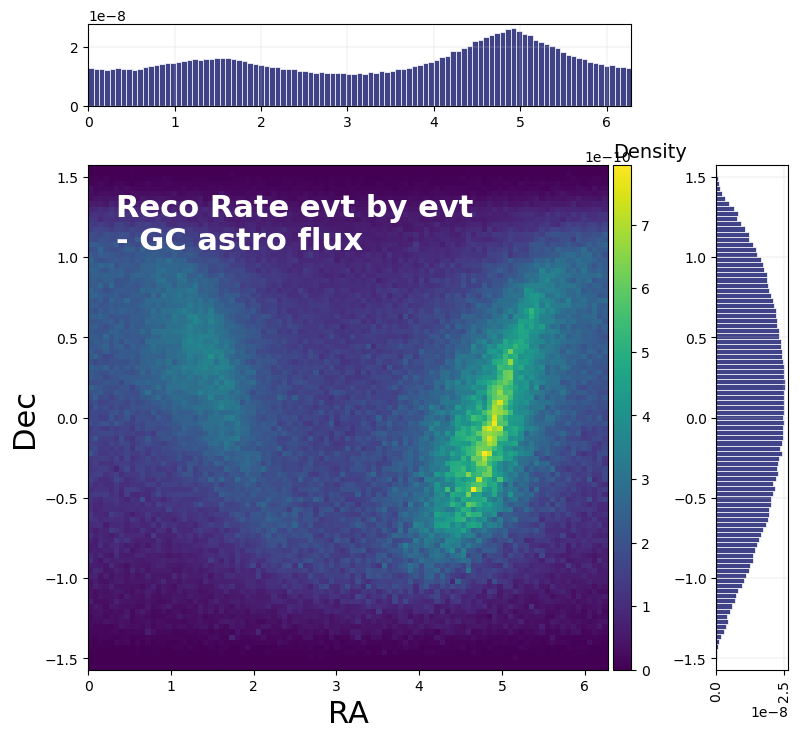

In [9]:
# plot_projections(GC_recorate_evtbyevt, (Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])), r'$\psi$', r'$E[GeV]$', 'Reco Rate evt by evt \n- GC astro flux', norm=None, min=None, zlogscale=False)
plot_projections(GC_recorate_evtbyevt, ( edges1, edges2 ), r'RA', r'Dec', 'Reco Rate evt by evt \n- GC astro flux', norm=None, min=None, zlogscale=False)


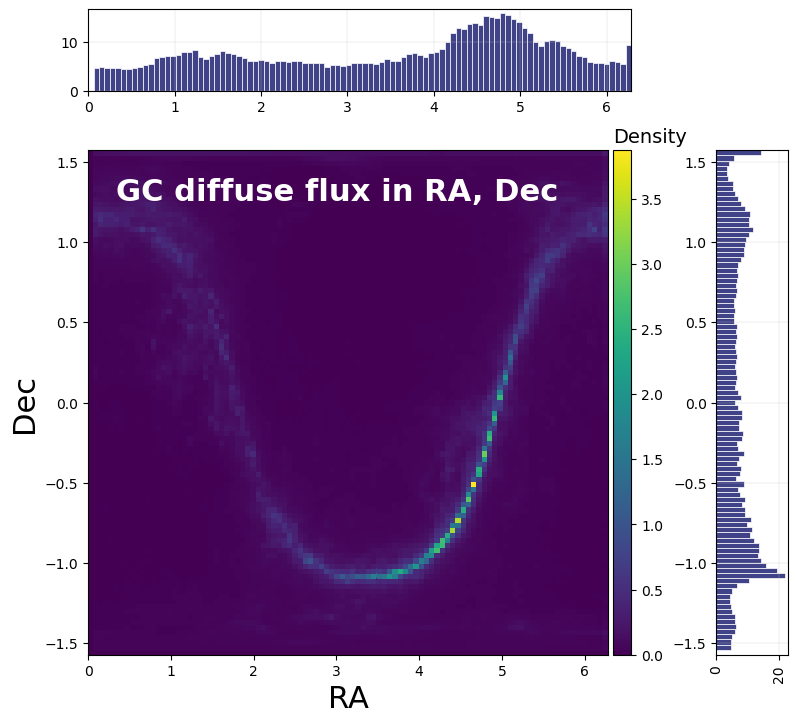

In [39]:
RAedges = np.linspace(0, 2*np.pi, 100)
Decedges = np.linspace(-np.pi/2., np.pi/2., 100)
RAcen = RAedges[0:-1] + np.diff(RAedges)
Decen = Decedges[0:-1] + np.diff(Decedges)
RAmesh, Decmesh = np.meshgrid(RAcen, Decen)
coords_plot = SkyCoord(RAmesh.flatten(), Decmesh.flatten(), frame='icrs', unit='rad')
weights = hpix.interpolate_bilinear_skycoord(coords_plot, pi0)

GC_flux, edges1, edges2 = np.histogram2d(RAmesh.flatten(), Decmesh.flatten(), bins = (RAedges, Decedges), weights=weights)
plot_projections(GC_flux, (RAedges,  Decedges), 'RA', 'Dec', 'GC diffuse flux in RA, Dec', norm=None, min=None, zlogscale=False)

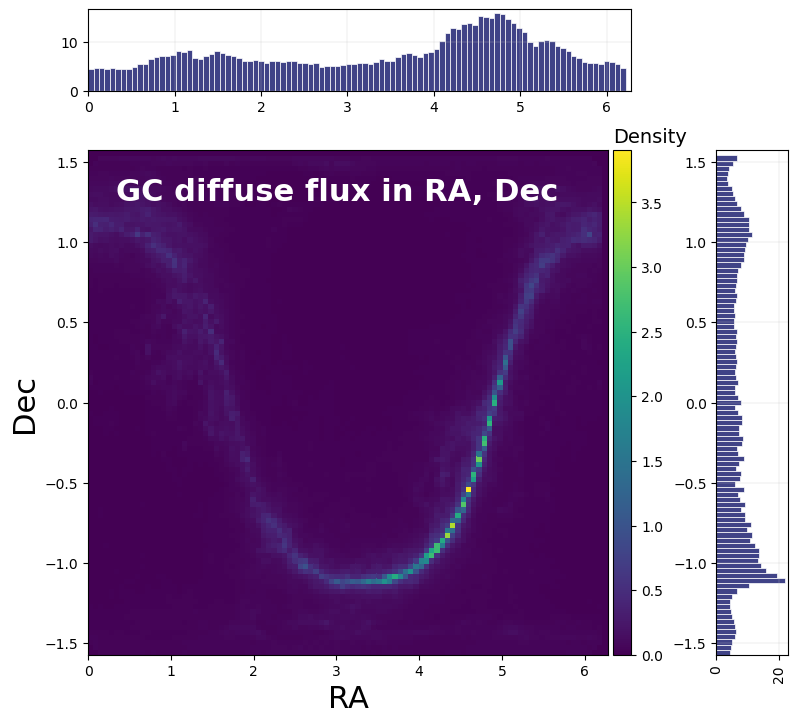

In [38]:
Z = interp(RAmesh, Decmesh)
loc = np.where(Z!=Z)
Z[loc] = 0
plot_projections(Z.T, (RAedges,  Decedges), 'RA', 'Dec', 'GC diffuse flux in RA, Dec', norm=None, min=None, zlogscale=False)

In [28]:
RAhist = np.histogram2d(true_RA, reco_RA, bins=( np.linspace(0, 2*np.pi, 50), np.linspace(0, 2*np.pi, 60) ))


(array([[8530., 6800., 5025., ..., 3956., 4822., 6443.],
        [5969., 8384., 7454., ..., 3222., 3818., 4740.],
        [4471., 5605., 8003., ..., 2680., 3152., 3779.],
        ...,
        [3707., 3056., 2592., ..., 7826., 5707., 4526.],
        [4683., 3780., 3287., ..., 7528., 8339., 5983.],
        [6518., 4800., 4046., ..., 5234., 6987., 8541.]]),
 array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
        0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
        1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
        1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
        2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
        3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
        3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
        4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
        5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
        5.77027222, 5.89850049,

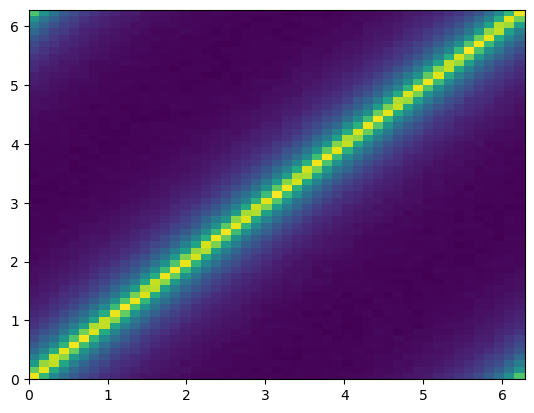

In [29]:
plt.hist2d(true_RA, reco_RA, bins=( np.linspace(0, 2*np.pi, 50), np.linspace(0, 2*np.pi, 60) ))

(array([[1.100e+01, 4.800e+01, 8.800e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.700e+01, 1.400e+02, 2.430e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.900e+01, 1.120e+02, 3.490e+02, ..., 1.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [1.000e+00, 0.000e+00, 2.000e+00, ..., 1.768e+03, 6.970e+02,
         8.900e+01],
        [0.000e+00, 0.000e+00, 1.000e+00, ..., 1.289e+03, 9.280e+02,
         1.710e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.870e+02, 3.840e+02,
         1.700e+02]]),
 array([-1.57079633, -1.50668219, -1.44256806, -1.37845392, -1.31433978,
        -1.25022565, -1.18611151, -1.12199738, -1.05788324, -0.9937691 ,
        -0.92965497, -0.86554083, -0.8014267 , -0.73731256, -0.67319843,
        -0.60908429, -0.54497015, -0.48085602, -0.41674188, -0.35262775,
        -0.28851361, -0.22439948, -0.16028534, -0.0961712 , -0.03205707,
         0.03205707,  0.0961712 ,  0.16028534,  0.22439948,  0.28851361,
       

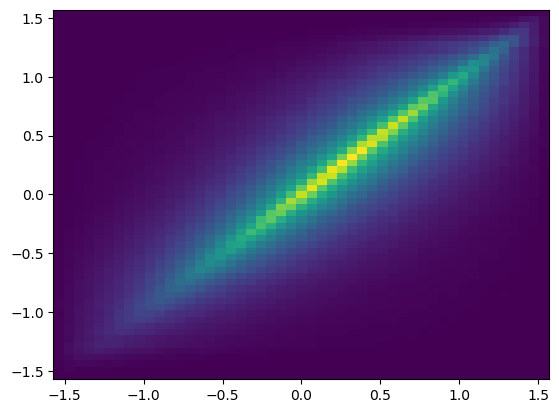

In [47]:
plt.hist2d(true_Dec, reco_Dec, bins=( np.linspace(-np.pi/2.,np.pi/2., 50), np.linspace(-np.pi/2.,np.pi/2., 60) ))

(array([[8.900e+01, 1.760e+02, 1.890e+02, ..., 4.000e+00, 0.000e+00,
         0.000e+00],
        [1.590e+02, 4.760e+02, 6.200e+02, ..., 8.000e+00, 7.000e+00,
         2.000e+00],
        [1.590e+02, 5.320e+02, 9.680e+02, ..., 1.800e+01, 5.000e+00,
         4.000e+00],
        ...,
        [4.000e+00, 7.000e+00, 1.200e+01, ..., 1.639e+03, 8.080e+02,
         2.390e+02],
        [0.000e+00, 3.000e+00, 5.000e+00, ..., 1.145e+03, 8.170e+02,
         2.650e+02],
        [1.000e+00, 0.000e+00, 6.000e+00, ..., 2.840e+02, 3.430e+02,
         1.810e+02]]),
 array([  0.        ,   3.67346939,   7.34693878,  11.02040816,
         14.69387755,  18.36734694,  22.04081633,  25.71428571,
         29.3877551 ,  33.06122449,  36.73469388,  40.40816327,
         44.08163265,  47.75510204,  51.42857143,  55.10204082,
         58.7755102 ,  62.44897959,  66.12244898,  69.79591837,
         73.46938776,  77.14285714,  80.81632653,  84.48979592,
         88.16326531,  91.83673469,  95.51020408,  99.1836734

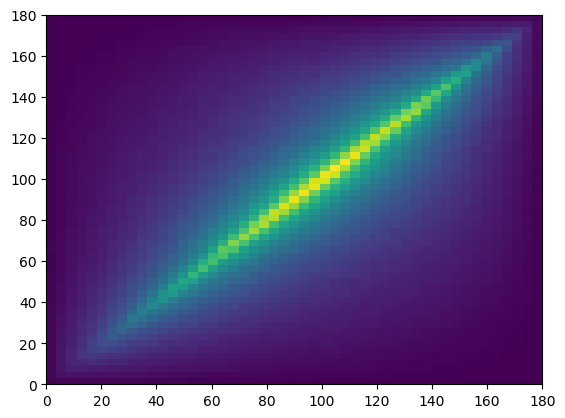

In [32]:
plt.hist2d(true_psi, reco_psi, bins=( np.linspace(0, 180, 50), np.linspace(0.,180., 60) ))